<h1><center>Natural Language Processing - Twitter Analysis</center></h1>

## Problem Statement

### Context

Twitter's massive user base of 330 million monthly active users presents a direct avenue for businesses to connect with a broad audience. However, the vast amount of information on the platform makes it challenging for brands to swiftly detect negative social mentions that may impact their reputation. To tackle this, sentiment analysis has become a crucial tool in social media marketing, enabling businesses to monitor emotions in conversations, understand customer sentiments, and gain insights to stay ahead in their industry.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.

### Objective

The aim of this project is to build a sentimental analysis model that classify the sentiment of tweets into the positive, neutral & negative.

### Data Dictionary

* tweet_id - A unique identifier for each tweet                                                          
* airline_sentiment - The sentiment label of the tweet, such as positive, negative, or neutral                                               
* airline_sentiment_confidence - The confidence level associated with the sentiment label                               
* negativereason - A category indicating the reason for negative sentiment                                                   
* negativereason_confidence - The confidence level associated with the negative reason                                    
*airline - The airline associated with the tweet                                                                   
* airline_sentiment_gold - Gold standard sentiment label                                               
* name - The username of the tweet author    
* retweet_count - The number of times the tweet has been retweeted
* text - The actual text content of the tweet.
* tweet_coord - Coordinates of the tweet
* tweet_created - The timestamp when the tweet was created
* tweet_location - The location mentioned in the tweet
* user_timezone - The timezone of the tweet author

## Importing necessary libraries

In [ ]:
!pip install contractions
!pip install wordcloud
!pip install vaderSentiment
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded to 2 decimal places

import re, string, unicodedata                          # Import Regex, string and unicodedata
import contractions                                     # Import contractions library
from bs4 import BeautifulSoup                           # Import BeautifulSoup
import nltk                                             # Import Natural Language Tool-Kit


nltk.download('stopwords')                              # Download Stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords                       # Import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer
from nltk.stem import PorterStemmer                     # Import Stemmer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, wordcloud

from sklearn.model_selection import train_test_split # Split Data

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

from sklearn.linear_model import LogisticRegression       # Import Logistic Regression
from sklearn.ensemble import RandomForestClassifier       # Import Random forest Classifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score # Performance Metrics


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Loading the dataset

In [ ]:
data = pd.read_csv('Tweets.csv')
df = data.copy()

## Data Overview

**Read the dataset**

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.00,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.35,NaN,0.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.68,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.00,Bad Flight,0.70,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.00,Can't Tell,1.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**Check the shape of the data**

In [ ]:
df.shape

(14640, 15)

The dataset has 14,640 rows and 15 columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Data is stored in preferred format

**Check the missing values**

In [ ]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

There are some null values present in the dataset

## Exploratory Data Analysis

**Plot the distribution of all tweets among each airline & plot the distribution of sentiment across all the tweets**

In [ ]:
df['airline'].value_counts().sort_values(ascending = False)

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

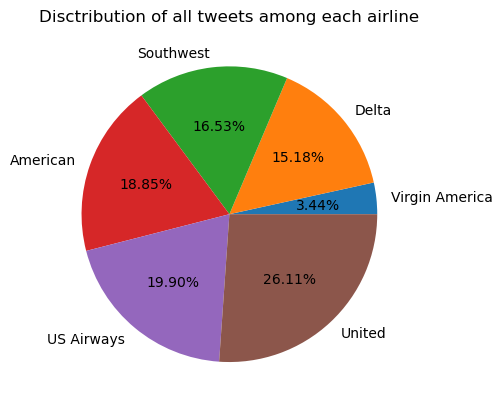

In [ ]:
air = df['airline'].value_counts().sort_values()
ax = plt.pie(x = air, labels=air.index, autopct = '%.2f%%')
plt.title('Disctribution of all tweets among each airline');

United has the highest share of tweets

In [ ]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

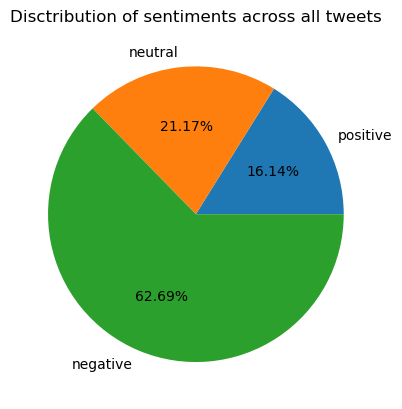

In [ ]:
senti = df['airline_sentiment'].value_counts().sort_values()
ax = plt.pie(x = senti, labels=senti.index, autopct = '%.2f%%')
plt.title('Disctribution of sentiments across all tweets');

Most of the reviews are negative

**Plot the distribution of sentiment of tweets for each airline & plot the distribution of all the negative reasons**

In [ ]:
air_senti = df.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()
air_senti

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


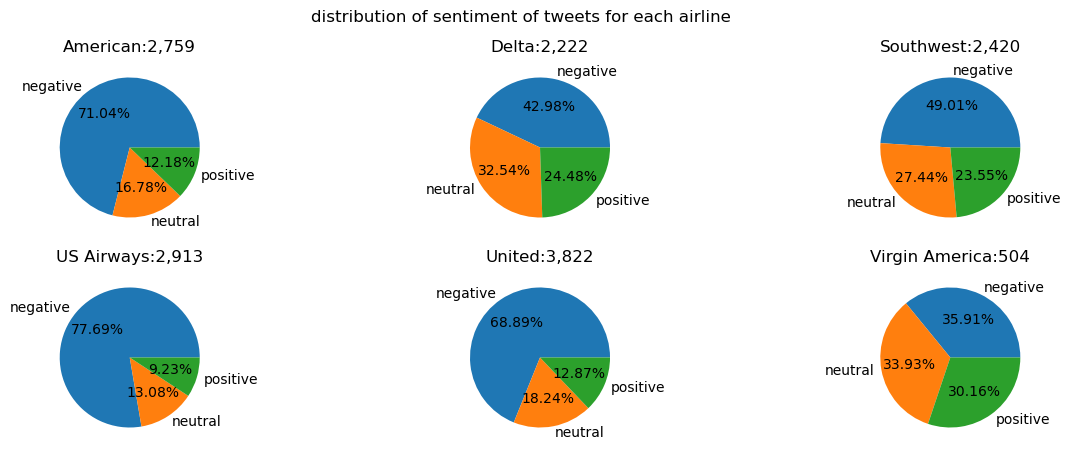

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (15, 5))
axes = axes.flatten()
for i, ax in zip(range(0, 6), axes):
    temp = air_senti.iloc[i]
    ax.pie(x = temp, labels = temp.index, autopct = '%.2f%%')
    ax.set_title(f"{air_senti.index[i]}:{format(air_senti.values[i].sum(),',')}")

plt.suptitle("distribution of sentiment of tweets for each airline")
plt.show()

In [ ]:
sent = air_senti.T
sent

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,1960,955,1186,2263,2633,181
neutral,463,723,664,381,697,171
positive,336,544,570,269,492,152


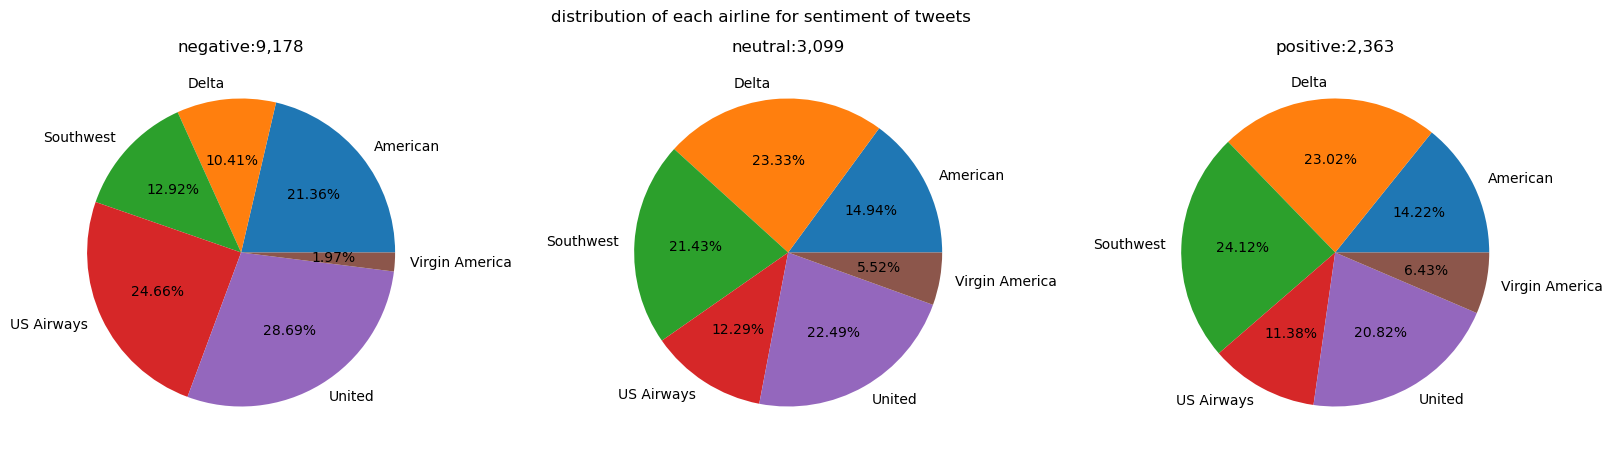

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
axes = axes.flatten()
for i, ax in zip(range(0, 3), axes):
    temp = sent.iloc[i]
    ax.pie(x = temp, labels = temp.index, autopct = '%.2f%%')
    ax.set_title(f"{sent.index[i]}:{format(sent.values[i].sum(),',')}")

plt.suptitle("distribution of each airline for sentiment of tweets ")
plt.show()

United airlines have got the most of the negative reviews however US airways have got highest percentage of negative reviews

In [ ]:
# function to create labeled barplots

def labeled_barplot(data, feature, hue=None, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    hue: whether to groupby another dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column

    ax = sns.countplot(
        data=data,
        x=feature,
        hue=hue,
        palette='viridis',
        order = data[feature].value_counts().index,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()  # show the plot

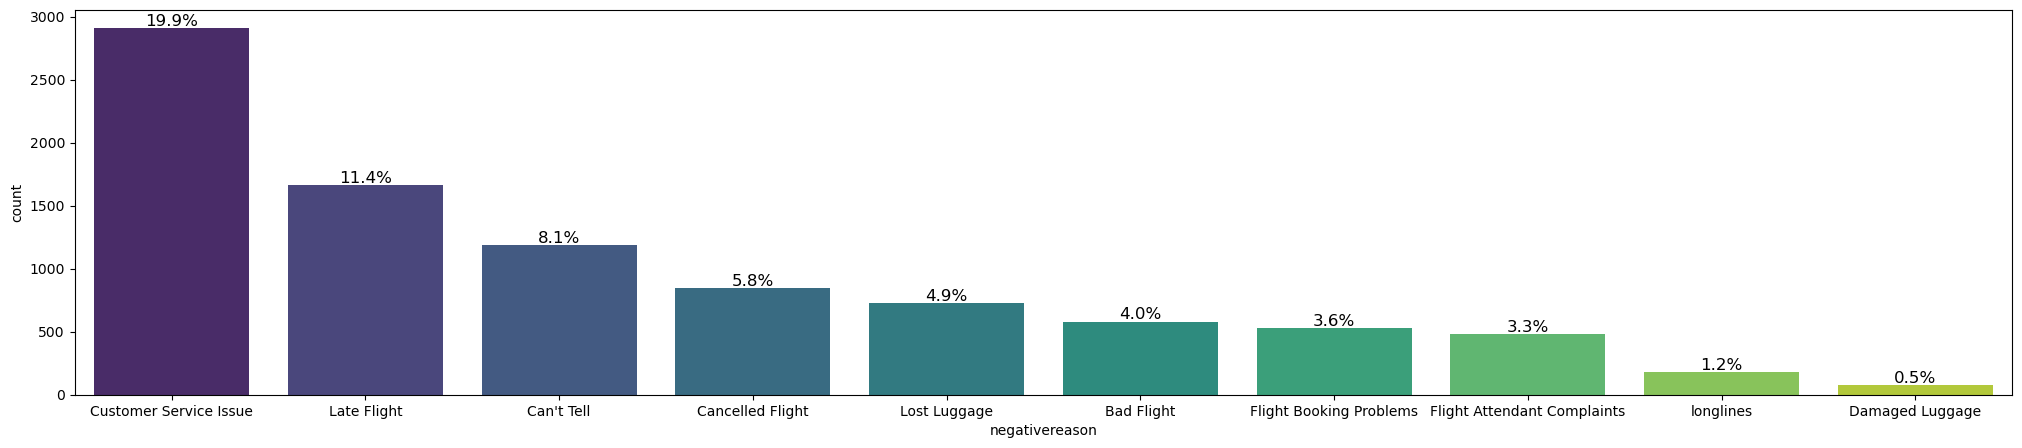

In [ ]:
plt.figure(figsize = (25, 5))
labeled_barplot(df,'negativereason',perc=True)

Customer service issue is the top reason for negative reviews accounting for ~20% of the negative reviews

**Plot the word cloud graph of tweets for positive and negative sentiment separately**

In [ ]:
negative=df[df['airline_sentiment']=='negative'].text
positive=df[df['airline_sentiment']=='positive'].text
neutral=df[df['airline_sentiment']=='neutral'].text

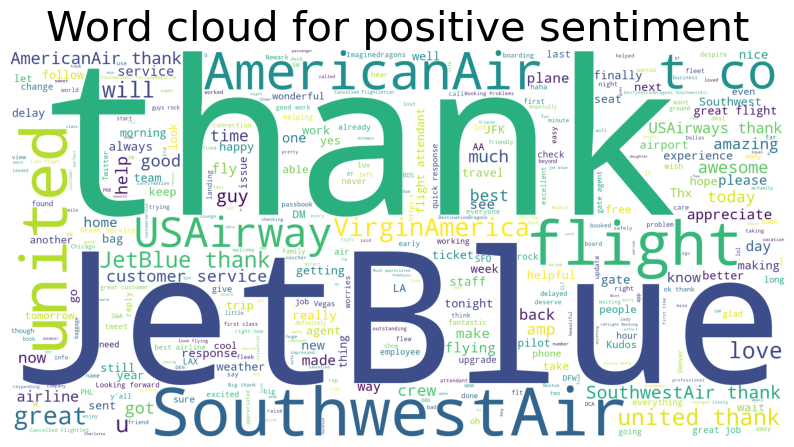

In [ ]:
plt.figure(figsize=(10,10), frameon=True)
world_cloud_positive=WordCloud(min_font_size=10,max_words=4000,width=2000,height=1000, background_color='white', colormap='viridis').generate("".join(positive))
plt.imshow(world_cloud_positive)
plt.axis('off')
plt.title('Word cloud for positive sentiment', fontsize=30);

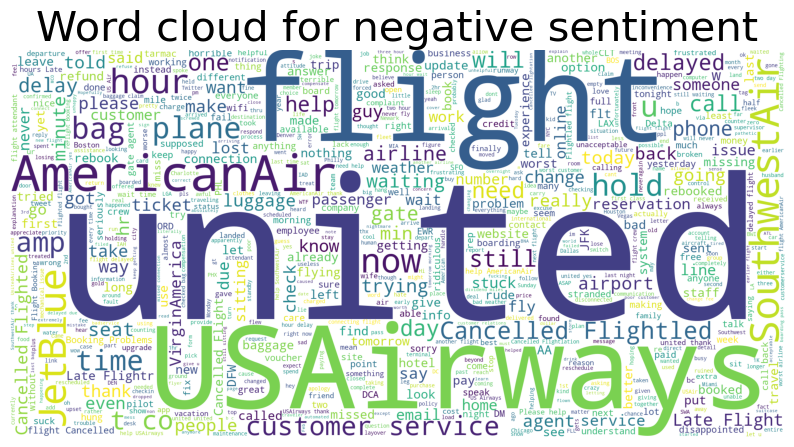

In [ ]:
plt.figure(figsize=(10,10), frameon=True)
world_cloud_negative=WordCloud(min_font_size=10,max_words=4000,width=2000,height=1000, background_color='white', colormap='viridis').generate("".join(negative))
plt.imshow(world_cloud_negative)
plt.axis('off')
plt.title('Word cloud for negative sentiment', fontsize=30);

## Data Preparation for Modeling

- Drop all unnecessary columns
- Remove html tags
- Replace contractions in string(e.g. replace I'm --> I am) and so on
- Remove numbers
- Tokenization
- To remove Stopwords
- Lemmatized data

In [ ]:
# drop unnecessary columns
needed_columns = ['airline_sentiment', 'text']
df = df[needed_columns]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [ ]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# remove the url's present in the text
def remove_url(text):
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove the mentions in the tweets
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text = remove_url(text)
    text = remove_mention(text)
    return text
df['text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


In [ ]:
# Tokenization of data
df['text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
df.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


In [ ]:
# removing stopwords adding flight as an extra stopword
stopwords = stopwords.words('english')
custom_remove_list = ['flight']
stopwords = list(set(stopwords)) + custom_remove_list
lemmatizer = WordNetLemmatizer()

# remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# remove the hashtags
def remove_hash(text):
   """Remove hashtags from list of tokenized words"""
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df['text'] = df.apply(lambda row: normalize(row['text']), axis=1)
df.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainment guests face little recourse
4,negative,really big bad thing


## Model Building

### Using Bag of Words (BoW) / countvectorizer

- Intialize countvectorizer and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build ML models on train data
- Test the model on testing data
- Plot the Confusion matrix

In [ ]:
# set independent variable for classification model
targets = sorted(df.airline_sentiment.unique())
print(targets)

['negative', 'neutral', 'positive']


In [ ]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer
# set the max number of features at 1000
bow_vec = CountVectorizer(max_features=1000)
data_features = bow_vec.fit_transform(df['text'])
# convert the data features to array
data_features = data_features.toarray()

In [ ]:
data_features.shape

(14640, 1000)

In [ ]:
# split data into training and testing set
X = data_features
y = df.airline_sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=42)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(y_test,logreg_pred)
print("Test accuracy for Logistic Regression with BoW: {:.2f}%".format(logreg_acc*100))

Test accuracy for Logistic Regression with BoW: 79.48%


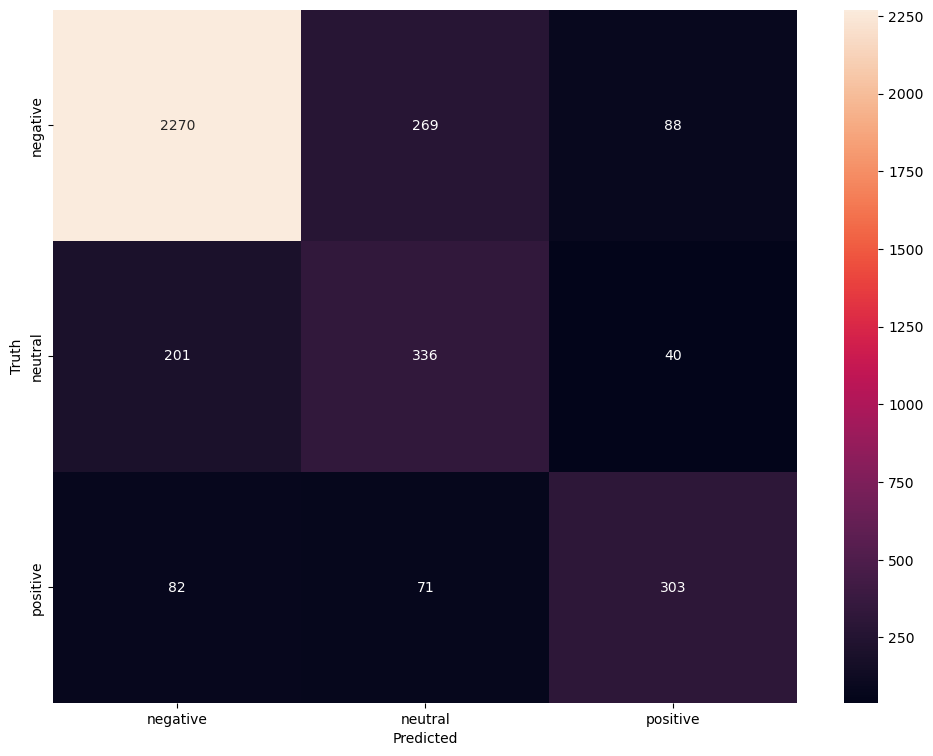

In [ ]:
from sklearn.metrics import confusion_matrix
#create confusion matrix
cm=confusion_matrix(y_test, logreg_pred)

plt.figure(figsize=(12,9))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=targets , yticklabels= targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[2270  269   88]
 [ 201  336   40]
 [  82   71  303]]


              precision    recall  f1-score   support

    negative       0.89      0.86      0.88      2627
     neutral       0.50      0.58      0.54       577
    positive       0.70      0.66      0.68       456

    accuracy                           0.79      3660
   macro avg       0.70      0.70      0.70      3660
weighted avg       0.80      0.79      0.80      3660



Due to imbalanced data, as negative reviews were more, the number of true positives for negative class is the highest

## Desicion Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
dt_pred = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)
print("Test accuracy for Decision Tree with BoW: {:.2f}%".format(dt_acc*100))

Test accuracy for Decision Tree with BoW: 69.15%


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Test accuracy for Random Forest with BoW: {:.2f}%".format(rf_acc*100))

Test accuracy for Random Forest with BoW: 78.09%


### Using TF-IDF (Term Frequency- Inverse Document Frequency)

- Intialize TF-IDF and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build ML models on train data
- Test the model on testing data
- Plot the Confusion matrix


In [ ]:
# Using TfidfVectorizer to convert text data to numbers.

tfidf_vect = TfidfVectorizer(max_features=1000)
data_features = tfidf_vect.fit_transform(df['text'])

data_features = data_features.toarray()

data_features.shape

(14640, 1000)

In [ ]:
# Store dependent & independent variables
X = data_features
y = df.airline_sentiment

In [ ]:
# Split data into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

## Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy for Logistic Regression with Tf-IDF: {:.2f}%".format(logreg_acc*100))

Test accuracy for Logistic Regression with Tf-IDF: 80.93%


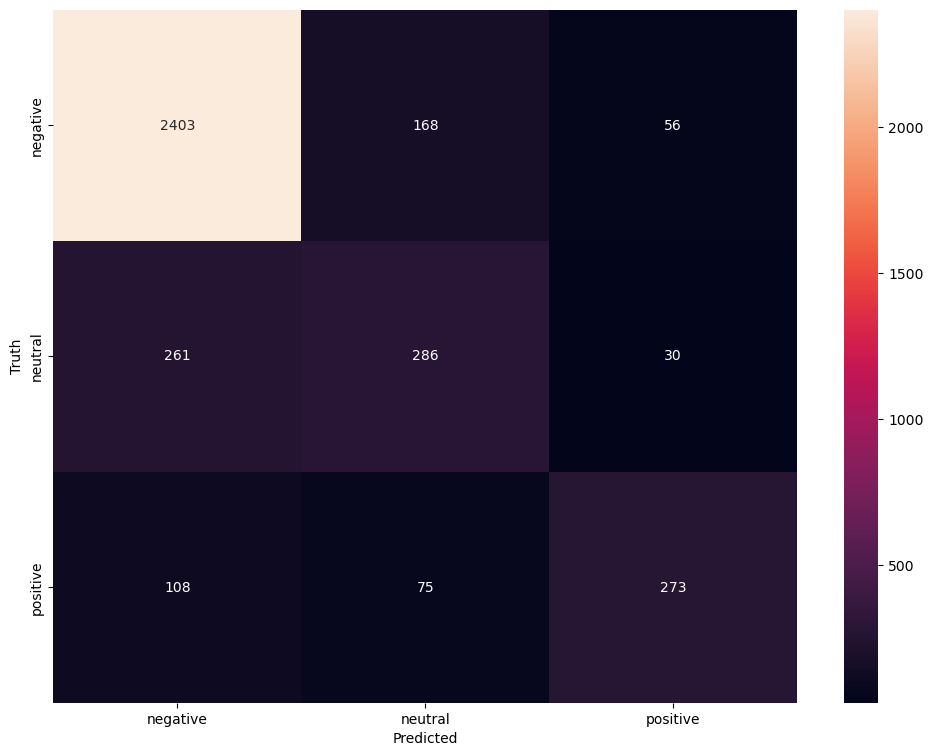

In [ ]:
from sklearn.metrics import confusion_matrix
#create confusion matrix
cm=confusion_matrix(y_test, logreg_pred)

plt.figure(figsize=(12,9))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=targets , yticklabels= targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[2403  168   56]
 [ 261  286   30]
 [ 108   75  273]]


              precision    recall  f1-score   support

    negative       0.87      0.91      0.89      2627
     neutral       0.54      0.50      0.52       577
    positive       0.76      0.60      0.67       456

    accuracy                           0.81      3660
   macro avg       0.72      0.67      0.69      3660
weighted avg       0.80      0.81      0.80      3660



## Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
dt_pred = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)
print("Test accuracy for Decision Tree with TF-IDF: {:.2f}%".format(dt_acc*100))

Test accuracy for Decision Tree with TF-IDF: 72.81%


## Random Forest

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Test accuracy for Random Forest with TF-IDF: {:.2f}%".format(rf_acc*100))

Test accuracy for Random Forest with TF-IDF: 80.41%


## Summary

---



A dataset on tweets regarding US Airline was analysed. Basic EDA was performed to visiluaze the patterns in the dataset. For Sentiment Analysis, the twitter textual data was cleaned, tokenized and normalized before feeding as input to the ML models. 2 vectorization methods were used Bag of Words and TF-IDF and 3 ML models namely Logistic Regression, Decision Tree & Random Forest. The results are as one might expect TF-IDF had a higher accuarcy than BoW. As due to its weighting, it tends to perform better than Bag of words. Accuracy wise: Logistic Regression > Random Forest > Decision Tree.

## Using Pre-trained model BERT

In [ ]:
!pip install transformers

In [ ]:
map_label = dict(enumerate(df['airline_sentiment'].factorize()[1]))
df['airline_sentiment'] = df['airline_sentiment'].factorize()[0]

In [ ]:
df.head()

,airline_sentiment,text
0,0,say
1,1,plus add commercials experience tacky
2,0,today must mean need take another trip
3,2,really aggressive blast obnoxious entertainment guests face little recourse
4,2,really big bad thing


In [ ]:
from transformers import BertModel, BertTokenizer

In [ ]:
MODEL = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL)

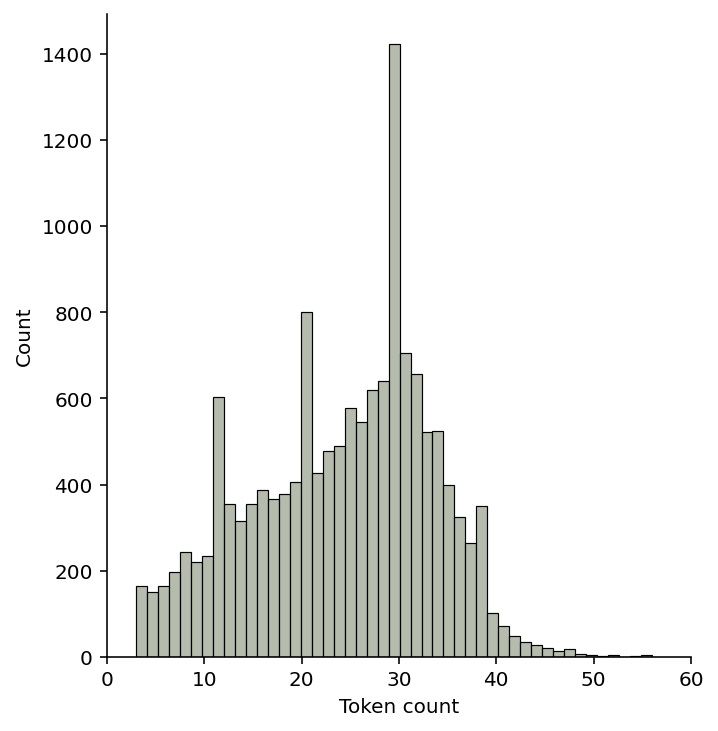

In [ ]:
tokens = [len(tokenizer.encode(text, max_length=512, truncation=True)) for text in df.text]
sns.displot(tokens)
plt.xlim([0, 60]);
plt.xlabel('Token count');

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset, more info on how to build custom dataset can be
# found at https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class CustomDataset(Dataset):

    def __init__(
        self,
        tweets,
        labels,
        tokenizer,
        max_length
    ):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]

        tokenize = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'tweet': tweet,
            'input_ids': tokenize['input_ids'].flatten(),
            'attention_mask': tokenize['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
               }

In [ ]:
sentences = df.text.values
sentences = [sentence.strip() for sentence in sentences]
sent = sentences[5]
token = tokenizer.tokenize(sent)
print(token)
token_id = tokenizer.convert_tokens_to_ids(token)
print(token_id)

['seriously', 'would', 'pay', 'seat', 'play', 'really', 'bad', 'thing', 'fly', 'va']
[5667, 2052, 3477, 2835, 2377, 2428, 2919, 2518, 4875, 12436]


In [ ]:
MAX_LENGTH = 64
TEST_SIZE = 0.1
VALID_SIZE = 0.5
BATCH_SIZE = 16
NUM_WORKERS = 2

train_sampler, test_sampler = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)
valid_sampler, test_sampler = train_test_split(test_sampler, test_size=VALID_SIZE, random_state=RANDOM_STATE)

train_set = CustomDataset(
    train_sampler['text'].to_numpy(),
    train_sampler['labels'].to_numpy(),
    tokenizer,
    MAX_LENGTH
)
test_set = CustomDataset(
    test_sampler['text'].to_numpy(),
    test_sampler['labels'].to_numpy(),
    tokenizer,
    MAX_LENGTH
)
valid_set = CustomDataset(
    valid_sampler['text'].to_numpy(),
    valid_sampler['labels'].to_numpy(),
    tokenizer,
    MAX_LENGTH
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [ ]:
from torch import nn
class AirlineSentimentClassifier(nn.Module):

    def __init__(self, num_labels):
        super (AirlineSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL)
        self.dropout = nn.Dropout(p=0.2)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        out = self.classifier(pooled_output)
        return out


In [ ]:
model = AirlineSentimentClassifier(len(labels_map))
print(model)

# Move tensors to GPU on CUDA enables devices
if device:
    model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AirlineSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
n_epochs = 10
learning_rate =2e-5

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)

# Define scheduler
training_steps = len(train_loader)*n_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=training_steps
)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Track changes in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # Setting training and validation loss
    train_loss = []
    validation_loss = []
    tr_predictions = 0
    acc = 0
    val_predictions = 0

    ####################
    #  Train the model #
    ####################
    model = model.train()
    for data in train_loader:

        # Moving tensors to GPU on CUDA enabled devices
        if device:
            input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()
        # Clear the gradients of variables
        optimizer.zero_grad()

        #### Forward pass
        # Pass input through the model
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Compute batch loss
        loss = criterion(output, targets)
        # Convert output probabilities to class probabilities
        _, pred = torch.max(output, 1)
        # Track correct predictions
        tr_predictions += torch.sum(pred == targets)

        #### Backward Pass
        # Compute gradients wrt to model parameters
        loss.backward()
        # To avoid exploding gradients, we clip the gradients of the model
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Perform parameter update
        optimizer.step()
        # Update learning rate
        scheduler.step()
        # Update loss per mini batches
        train_loss.append(loss.item())

    ######################
    # Validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data in valid_loader:

            # Moving tensors to GPU on CUDA enabled devices
            if device:
                input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()

            #### Forward pass
            # Pass input through the model
            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            # Compute batch loss
            loss = criterion(output, targets)
            # Convert output probabilities to class probabilities
            _, pred = torch.max(output, 1)
            # Update loss per mini batches
            validation_loss.append(loss.item())
            # Track correct predictions
            val_predictions += torch.sum(pred == targets)

    # Compute accuracy
    train_accuracy = tr_predictions.double()/len(train_sampler)
    val_accuracy = val_predictions.double()/len(valid_sampler)

    # Print loss statistics
    print('Epoch: {}/{} \n\tTraining Loss: {:.6f} \n\tValidation Loss: {:.6f} \n\tTrain Accuracy: {:.6f} \n\tVal Accuracy: {:.6f}'.format(epoch,n_epochs, np.mean(train_loss), np.mean(validation_loss), train_accuracy, val_accuracy))

    # Save model if validation loss is decreased
    if val_accuracy > acc:
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_base_fine_tuned.pt')
        acc = val_accuracy

Epoch: 1/10 
	Training Loss: 0.478485 
	Validation Loss: 0.426510 
	Train Accuracy: 0.813221 
	Val Accuracy: 0.848361
Saving model...
Epoch: 2/10 
	Training Loss: 0.251598 
	Validation Loss: 0.587404 
	Train Accuracy: 0.912720 
	Val Accuracy: 0.837432
Saving model...
Epoch: 3/10 
	Training Loss: 0.147462 
	Validation Loss: 0.694001 
	Train Accuracy: 0.958333 
	Val Accuracy: 0.848361
Saving model...
Epoch: 4/10 
	Training Loss: 0.095958 
	Validation Loss: 0.852052 
	Train Accuracy: 0.976548 
	Val Accuracy: 0.841530
Saving model...
Epoch: 5/10 
	Training Loss: 0.062927 
	Validation Loss: 0.967488 
	Train Accuracy: 0.985504 
	Val Accuracy: 0.842896
Saving model...
Epoch: 6/10 
	Training Loss: 0.042360 
	Validation Loss: 1.066000 
	Train Accuracy: 0.990437 
	Val Accuracy: 0.840164
Saving model...
Epoch: 7/10 
	Training Loss: 0.032142 
	Validation Loss: 1.132496 
	Train Accuracy: 0.992410 
	Val Accuracy: 0.833333
Saving model...
Epoch: 8/10 
	Training Loss: 0.024429 
	Validation Loss: 1.184

In [ ]:
# Track test loss
test_loss = 0.0
class_predictions = list(0. for i in range(3))
class_total = list(0. for i in range(3))
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:

        # Moving tensors to GPU on CUDA enabled devices
        if device:
            input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()

        #### Forward pass
        # Pass input through the model
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Compute batch loss
        loss = criterion(output, targets)
        # Update loss
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        predictions.extend(pred)
        labels.extend(targets)

predictions = torch.stack(predictions) if not device else torch.stack(predictions).cpu()
labels = torch.stack(labels) if not device else torch.stack(labels).cpu()





In [ ]:
print(classification_report(predictions, labels, target_names=['neutral', 'positive','negative']))

              precision    recall  f1-score   support

     neutral       0.68      0.71      0.69       146
    positive       0.79      0.81      0.80       118
    negative       0.92      0.90      0.91       468

    accuracy                           0.85       732
   macro avg       0.79      0.81      0.80       732
weighted avg       0.85      0.85      0.85       732



Getting an accuracy of 85% on BERT